<a href="https://colab.research.google.com/github/kartk/ML/blob/main/Decision_Trees_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

I've written the code as a part of class and explained the details below.

In [ ]:
!pip install pptree

  Created wheel for pptree: filename=pptree-3.1-cp36-none-any.whl size=4632 sha256=05735ed945a892b3e519c682bc23d9335ae6bf93fb906a9da592e4bc74ffe241
  Stored in directory: /root/.cache/pip/wheels/ff/bf/ee/8b67eb5467e12cf1bd0125df70d8c9f076bd7ea225b5bcea9b
Successfully built pptree


In [ ]:
import numpy as np
from typing import List, Tuple
from ppbtree import print_tree
import matplotlib.pyplot as plt
from collections import Counter 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class Node:
  """
    @class Node: used to store the binary tree
  """
  def __init__(self, data):
    self.left = None
    self.right = None
    self.data = data
  def pretty_print(self):
      print_tree(self,nameattr="data")


class DecisionTree:
  """
    @class DecisionTree: Logic for the decision tree implementation
  """
  
  def __init__(self,data:np.array = None,k:int=None, m:int=None, d:int = None, s:int = None )-> None:
    """
      constructor:
        Input:
            data  : data to used for training and testing (Optional)
            k     : Number of features the data should have (Optional)
            m     : Size of the data  (Optional)
            d     : Depth up to which to grow the tree (Optional)
            s     : Sampling size (Optional)
    """


    assert ((data is None) and ( m is not None)) or ((data is not None) and ( m is None)), "Both m(size) and data can't be empty" 
    assert ((d is None) and (s is not None)) or ((d is not None) and (s is None)) or ((d is None) and (s is None)), "Give either d(depth size) or s(sample size), not both!"
    self.k = data.shape[1] if data is not None else k
    self.m = data.shape[0] if data is not None else m
    self.data = data if data is not None else DecisionTree.datagenerator2(m) if k is None else DecisionTree.datagenerator(k, m)    
    self.d = d
    self.s = s
    self.tree = None
    self.nodes = Counter()
  
  @classmethod
  def datagenerator(self, k:int, m:int)->List[List[int]]:
    """
    Generate data accoriding to the given specification (Q1)
    Input:
      k: number of features
      m: number of data points
    Returns:
      Numpy array of size (m,k+1)
    """
    w_den = sum([np.power(0.9, i) for i in range(2, k+1)])
    data = [[0 for _ in range(k+1)] for _ in range(m)]
    for i in range(m):
      for j in range(k):
        if j == 0 :
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
        if (j >= 1):
          data[i][j] = data[i][j-1] if np.random.random() > 0.25 else 1-data[i][j-1]
      data[i][k] = data[i][0] if (sum([ np.power(0.9, j+2)/w_den * X_j for j, X_j in enumerate(data[i][1:])]) >= 0.5) else (1 - data[i][0])
    return np.array(data)

  @classmethod
  def datagenerator2(self, m:int)->np.array:
    """
    Generate data accoriding to the given specification (Q2)
    Input:
      m: number of data points
    Returns:
      Numpy array of size (m,k)
    """
    data = [[0 for _ in range(22)] for _ in range(m)]
    for i in range(m):
      for j in range(21):
        if j == 0 :
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
        if (j >= 1) and (j<=14):
          data[i][j] = data[i][j-1] if np.random.random() > 0.25 else 1-data[i][j-1]
        if (j >= 15) and (j<21):
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
      data[i][21] = np.bincount(data[i][8:15]).argmax() if data[i][0] else np.bincount(data[i][1:8]).argmax()
    return np.array(data)


  def regenerate_data(self, k=None, m=None)->None:
    """
      Function to regenerate data either. We regenerate the data and store it back as a member variable
    """
    self.data = DecisionTree.datagenerator(k if k else self.k , m if m else self.m) \
    if k is not None else DecisionTree.datagenerator2(m if m is not None else self.m)

  def entropy(self, vector:np.array)->np.array:
    """
      Function to calculate entropy H(Y)
    """
    P_0 = (vector == 0).sum(0) / len(vector)
    P_1 = (vector == 1).sum(0) / len(vector)
    H_Y = - P_0 * np.log2(P_0) - P_1 * np.log2(P_1)
    return H_Y

  def entropy_fit(self, data:np.array, depth=None)->None:
    """
      Function to fit decision tree using ID3, the fitted tree is stored as Node in member variable tree
      Input:
        data  : Data to fit the tree on
        depth : Max depth to grow the tree
    """
    X, Y = data[:,:-1], data[:,-1]
    if (
        (Y == 0).sum(0) == len(Y) or (Y == 1).sum(0) == len(Y) or 
        (depth and self. d is not None and (depth > self.d)) or 
        (self.s is not None and (len(Y) <= self.s))
      ):
      # Exit Condition for pruning by sample
      if self.s and (len(Y) <= self.s):
        b= np.bincount(data[:,-1])
        max_values = [i for i, x in enumerate(b) if x == max(b)]
        if len(max_values) == 1:
          return Node(f"Y={max_values[0]}")
        else :
          if np.random.random()>0.5:
            return Node(f"Y={max_values[1]}")
          return Node(f"Y={max_values[0]}")
      # Exit Condition for pruning by depth
      if depth and self. d and (depth > self.d):
        return Node(f"Y={np.bincount(data[:,-1]).argmax()}")
      # Exit condition when all Y values are same
      return Node("Y=0") if (Y == 0).sum(0) == len(Y) else Node("Y=1")
    # Calculating H(Y)
    H_Y = self.entropy(Y)

    # # Calculating H(Y|X)
    cond_X_Y = []
    for i in range(X.shape[1]):
      P_X_0 = (X[:,i] == 0).sum(0) / len(X[:,i])
      P_X_1 = (X[:,i] == 1).sum(0) / len(X[:,i])
      H_Y_X_0 = max(0, self.entropy(Y[np.where(X[:,i]==0)]))
      H_Y_X_1 = max(0, self.entropy(Y[np.where(X[:,i]==1)]))
      cond_X_Y.append(P_X_0 * H_Y_X_0 + P_X_1 * H_Y_X_1)

    # Calculating IG
    IG = H_Y - cond_X_Y

    # Pick the index which has the maximum IG and split on the same
    max_IG = np.argmax(IG)

    # Build a node based on the picked node
    self.nodes[max_IG] += 1
    node = Node(max_IG)

    # Left child would correspond to choosing data where X_maxig == 0
    node.left = self.entropy_fit(data[np.where(data[:,max_IG] == 0)],
                                 depth+1 if depth!=None else None)
    # Left child would correspond to choosing data where X_maxig == 1
    node.right = self.entropy_fit(data[np.where(data[:,max_IG] == 1)], 
                                  depth+1 if depth!=None else None)
    return node

  
  def gini_fit(self, data:np.array) -> None:
    """
      Function to fit decision tree using Gini index, the fitted tree is stored as Node in member variable tree
      Input:
        data  : Data to fit the tree on
    """

    # Exit condition where all the Y values of data is same 
    if (((data[:,-1]==0).sum(0) == len(data[:,-1])) or ((data[:,-1]==1).sum(0) == len(data[:,-1])) ):
      return Node("Y=0") if (data[:,-1] == 0).sum(0) == len(data[:,-1]) else Node("Y=1")
    gini = []

    # Calculate gini index for each column
    for c in range(data.shape[1] - 1):
      N = len(data[:,c])
      c_0 = data[np.where(data[:,c] == 0)]
      c_1 = data[np.where(data[:,c] == 1)]
      G_c_0 = 1 - ((len(c_0[np.where(c_0[:,-1] == 0)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0) - \
      ((len(c_0[np.where(c_0[:,-1] == 1)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0)
      G_c_1 = 1 - ((len(c_1[np.where(c_1[:,-1] == 0)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0) - \
      ((len(c_1[np.where(c_1[:,-1] == 1)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0)
      gini.append(c_0.shape[0] / N * G_c_0 + c_1.shape[0] / N * G_c_1)
    gini = np.array(gini)

    # Pick the column which has the minimum gini as the splitting variable
    split_var = gini.argmin()

    # Build a node based on the picked node
    node = Node(split_var)

    # Left child would correspond to choosing data where X_maxig == 0
    node.left = self.gini_fit(data[np.where(data[:,split_var] == 0)])
    
    # Left child would correspond to choosing data where X_maxig == 1
    node.right = self.gini_fit(data[np.where(data[:,split_var] == 1)])
    return node


  def train(self, method:str="entropy")->None:
    """
      Single function to call the training code
      Input:
        method: 
    """
    assert (method == "entropy") or (method == "gini"), "Invalid method argument, Please choose either entropy or gini"
    if method == "entropy":
      self.tree=self.entropy_fit(self.data, 0)
    elif method == "gini":
      self.tree=self.gini_fit(self.data)
  
  def get_y(self, vector:np.array, node:Node) -> int:
    """
      Function that recurses over the tree to get to the leaf
    """

    if type(node.data) == str :
      return int(node.data[-1])
    if vector[node.data] == 0:
      return self.get_y(vector, node.left)
    else:
      return self.get_y(vector, node.right)


  def predict(self, data:np.array)->List:
    """
      Function to predict on the given data
      Input:
        data: data on which to predict
    """

    assert self.tree is not None, "Model not trained yet!! Run train() before predict"
    correct_count = 0
    y = []
    for i in data:
      y.append(self.get_y(i, self.tree))
    return y
  
  def error(self, data:np.array=None) -> float:
    """
      Find the error the trained tree on the given data
      Input:
        data: data on which to find the error
    """
    d = data if data is not None else self.data
    y_hat = self.predict(d[:,:-1])
    y = d[:, -1]
    return 1 - (y_hat == y).sum(0) / len(y)
  
  def estimate_distribution_error(self,m:int=None, N:int=100) -> float:
    """
      Find the underlying distribution error. We do this by regenerating the data 
      N times and averaging the error from the regenerated data
      Input:
        m : size of the regenerated data
        N : number of times we need to regenerate the data 
    """
    error = 0
    for i in range(N):
      self.regenerate_data(k=self.k, m=m)
      error += self.error()
    return error / N



******

1) For a given value of k, m, (number of features, number of data points), write a function to generate a training
data set based on the above scheme.

Answer:

The class method DecisionTree.datagenerator generates data based on the current scheme



```
@classmethod
  def datagenerator(self, k:int, m:int)->List[List[int]]:
    """
    Generate data accoriding to the given specification (Q1)
    Input:
      k: number of features
      m: number of data points
    Returns:
      Numpy array of size (m,k+1)
    """
    w_den = sum([np.power(0.9, i) for i in range(2, k+1)])
    data = [[0 for _ in range(k+1)] for _ in range(m)]
    for i in range(m):
      for j in range(k):
        if j == 0 :
          data[i][j] = 0 if np.random.random() <= 0.5 else 1
        if (j >= 1):
          data[i][j] = data[i][j-1] if np.random.random() > 0.25 else 1-data[i][j-1]
      data[i][k] = data[i][0] if (sum([ np.power(0.9, j+2)/w_den * X_j for j, X_j in enumerate(data[i][1:])]) >= 0.5) else (1 - data[i][0])
    return np.array(data)
```



In [ ]:
data = DecisionTree.datagenerator(k=4, m=30)

In [ ]:
data

array([[0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1]])

Data can also be generated using the DecisionTree's contructor which internally calls the datagenerator function


```
DecisionTree(data,k, m)
```

data: data generated using datagenerator

k : Feature Size

m : Data size


We can either initialize using the already generated data by using the *data* argument or generate again by using *k and m arguments*




-----

2) Given a data set, write a function to fit a decision tree to that data based on splitting the variables by
maximizing the information gain (ID3). Additionally, return the training error of this tree on the data set,
err train ( f ˆ ) (Hint: this should be easy - why? ). It may be useful to have a function that takes a data set and a
variable, and returns the data set partitioned based on the values of that variable.

Answer:

The function to fit a decision tree to the given data is DecisionTree's train method. The trained decision tree is available as instance variable tree


```
def train(self, method:str="entropy")->None:
    """
      Single function to call the training code
      Input:
        method: 
    """
    assert (method == "entropy") or (method == "gini"), "Invalid method argument, Please choose either entropy or gini"
    if method == "entropy":
      self.tree=self.entropy_fit(self.data, 0)
    elif method == "gini":
      self.tree=self.gini_fit(self.data)
```

Based on the argument, it calls either entropy_fit, which fits using the ID3 algorithm or gini_fit which fits using gini index

Once trained, we can predict for other data using the DecisonTree's predict function

```
def predict(self, data:np.array)->List:
    """
      Function to predict on the given data
      Input:
        data: data on which to predict
    """

    assert self.tree is not None, "Model not trained yet!! Run train() before predict"
    correct_count = 0
    y = []
    for i in data:
      y.append(self.get_y(i, self.tree))
    return y
```


DecisionTree also has a method to get the error. We first predict and then calculate the misclassification error


```
def error(self, data:np.array=None) -> float:
    """
      Find the error the trained tree on the given data
      Input:
        data: data on which to find the error
    """
    d = data if data is not None else self.data
    y_hat = self.predict(d[:,:-1])
    y = d[:, -1]
    return 1 - (y_hat == y).sum(0) / len(y)
```



Answer to why Training error is easy to calculating training error is easy:

The decision tree is such that for any given data from the input training set, it gives the correct output, so the error will always be 0 for the training dataset

***

3) For k = 4 and m = 30, generate data and fit a decision tree to it. Does the ordering of the variables in the
decision tree make sense, based on the function that defines Y ? Why or why not? Draw the tree.

a)

In [ ]:
dt = DecisionTree( k=4, m=30)

In [ ]:
dt.data

array([[0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 0, 1],
       [1, 1, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 0, 1],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [ ]:
dt.train()

In [ ]:
dt.tree.pretty_print()

      ┌Y=1
    ┌1┤
    | └Y=0
  ┌0┤
  | | ┌Y=0
  | └1┤
  |   | ┌Y=0
  |   └2┤
  |     └Y=1
 3┤
  |   ┌Y=1
  | ┌2┤
  | | └Y=0
  └0┤
    | ┌Y=0
    └2┤
      └Y=1


I've used an external library called [pptree](https://github.com/clemtoy/pptree) to draw the graph.

Reading this graph is as below,

1) For a branch that is on top, treat it as the corresponding split variable == 0

2) For a branch that is on bottom, treat it as the corresponding split variable == 1

b)

In [ ]:
dt = DecisionTree(k=4,m=30)

In [ ]:
dt.data

array([[1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1],
       [0, 0, 1, 0, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 1, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0]])

In [ ]:
dt.train()

In [ ]:
dt.tree.pretty_print()

      ┌Y=1
    ┌3┤
    | | ┌Y=1
    | └2┤
    |   └Y=0
  ┌1┤
  | └Y=0
 0┤
  |   ┌Y=0
  | ┌3┤
  | | | ┌Y=0
  | | └1┤
  | |   └Y=1
  └2┤
    └Y=1


a) and b) shows two different trees for different data of same size. 

For me the tree makes sense as the Y value depends on the X[0] value and I expected it to be always part of all the paths in the tree and this is the behaviour I see in the multiple trials I've done 

****

4) Write a function that takes a decision tree and estimates its typical error on the underlying distribution err( f ˆ );
i.e., generate a lot of data according to the above scheme, and find the average error rate of this tree over that
data.

Answer: 

DecisionTree's estimate_distribution_error function finds the error on the underlying distribution



```
def estimate_distribution_error(self,m:int=None, N:int=100) -> float:
    """
      Find the underlying distribution error. We do this by regenerating the data 
      N times and averaging the error from the regenerated data
      Input:
        m : size of the regenerated data
        N : number of times we need to regenerate the data 
    """
    error = 0
    for i in range(N):
      self.regenerate_data(k=self.k, m=m)
      error += self.error()
    return error / N
```


In [ ]:
dt.estimate_distribution_error(N=1000)

0.03126666666666695

***

5) For k = 10, estimate the value of |err train ( f ˆ ) − err( f ˆ )| for a given m by repeatedly generating data sets, fitting
trees to those data sets, and estimating the true and training error. Do this for multiple m, and graph this
difference as a function of m. What can you say about the marginal value of additional training data?

err_train(f_hat) is always 0 and I do not see any case where it wouldn't be, so |err_train(f_hat) - err(f_hat)| is just err(f_hat) which is same as the previous question.

For k=10 :


In [ ]:
m_range = np.arange(10, 1000, 10)
error_distribution = []
for i in m_range:  
  dt = DecisionTree(k=10, m= i)
  dt.train()
  error_distribution.append(dt.estimate_distribution_error(N=100))

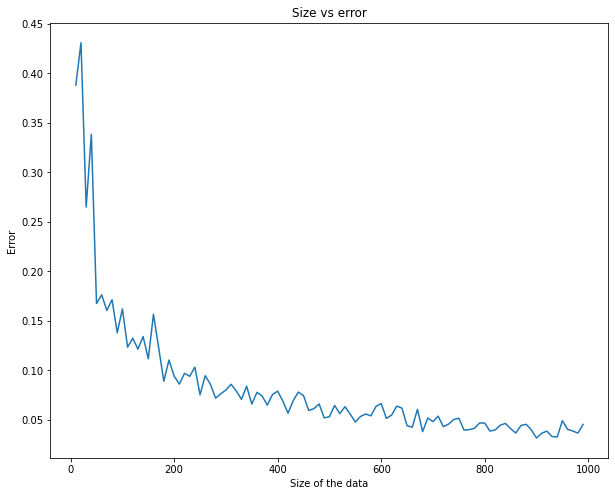

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(m_range, error_distribution)
plt.title("Size vs error")
plt.xlabel("Size of the data")
plt.ylabel("Error")
plt.show()

As we can see from the graph of size vs error, as we increase the size of the data there is a decrease in the error

***

6) Design an alternative metric for splitting the data, not based on information content / information gain. Repeat
the computation from (5) above for your metric, and compare the performance of your trees vs the ID3 trees.

The alternative approach for splitting that is implemented is GINI index, which measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen

Gini for each column is given by:

$ Gini = 1 - \sum_{i=1}^{n} (p_i)^2 $

$p_i$: probability of column values being 0 or 1 (In this case)


Steps:

1) Find Gini Index for all columns using the formula above 

2) Choose the column with smallest gini index as the splitting variable

3) Repeat the above two steps untill stopping condition

The implementation is as below:



```

def gini_fit(self, data):
    if (((data[:,-1]==0).sum(0) == len(data[:,-1])) or ((data[:,-1]==1).sum(0) == len(data[:,-1])) ):
      return Node("Y=0") if (data[:,-1] == 0).sum(0) == len(data[:,-1]) else Node("Y=1")
    gini = []
    for c in range(data.shape[1] - 1):
      N = len(data[:,c])
      c_0 = data[np.where(data[:,c] == 0)]
      c_1 = data[np.where(data[:,c] == 1)]
      G_c_0 = 1 - ((len(c_0[np.where(c_0[:,-1] == 0)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0) - ((len(c_0[np.where(c_0[:,-1] == 1)])/c_0.shape[0]) ** 2 if c_0.size != 0 else 0)
      G_c_1 = 1 - ((len(c_1[np.where(c_1[:,-1] == 0)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0) - ((len(c_1[np.where(c_1[:,-1] == 1)])/c_1.shape[0]) ** 2 if c_1.size != 0 else 0)
      gini.append(c_0.shape[0] / N * G_c_0 + c_1.shape[0] / N * G_c_1)
    gini = np.array(gini)
    split_var = gini.argmin()
    node = Node(split_var)
    node.left = self.gini_fit(data[np.where(data[:,split_var] == 0)])
    node.right = self.gini_fit(data[np.where(data[:,split_var] == 1)])
    return node

```



To train, we need to call the train method as below:


```
df.train("gini")
```




In [ ]:
dt = DecisionTree(k=4, m=30)
dt.train("gini")


In [ ]:
dt.tree.pretty_print()

      ┌Y=1
    ┌1┤
    | └Y=0
  ┌0┤
  | | ┌Y=0
  | └1┤
  |   └Y=1
 3┤
  |   ┌Y=1
  | ┌2┤
  | | └Y=0
  └0┤
    └Y=1


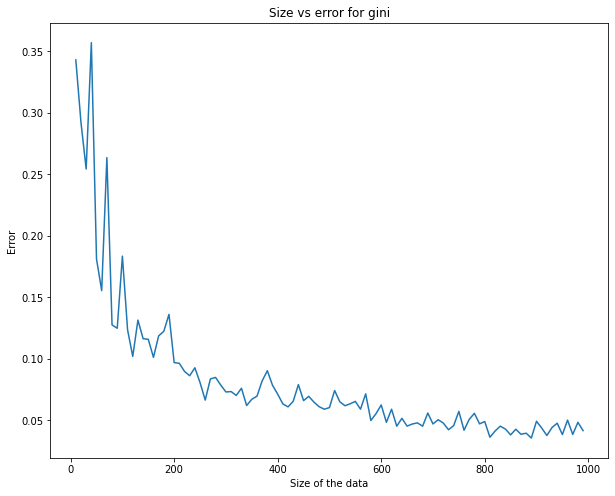

In [ ]:
m_range = np.arange(10, 1000, 10)
error_distribution_gini = []
for i in m_range:  
  dt = DecisionTree(k=10, m= i)
  dt.train("gini")
  error_distribution_gini.append(dt.estimate_distribution_error(N=100))
plt.figure(figsize=(10,8))
plt.plot(m_range, error_distribution_gini)
plt.title("Size vs error for gini")
plt.xlabel("Size of the data")
plt.ylabel("Error")
plt.show()


Comparing both:

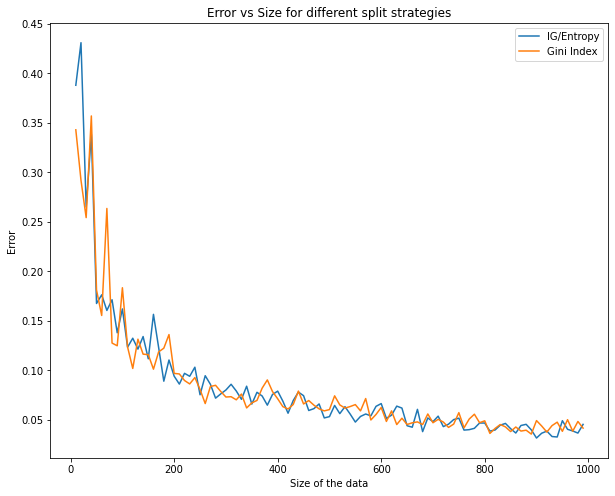

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(m_range,error_distribution, label="IG/Entropy")
plt.plot(m_range,error_distribution_gini, label="Gini Index")
plt.legend()
plt.xlabel("Size of the data")
plt.ylabel("Error")
plt.title("Error vs Size for different split strategies")
plt.show()

Gini and entropy seems to be fitting the tree with similar error